In [235]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [236]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions.
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            real_part = amplitude.real
            imag_part = amplitude.imag

            amplitude_str = ""
            if np.isclose(real_part, 0, atol=1e-2) and np.isclose(imag_part, 0, atol=1e-2):
                continue 

            if not np.isclose(real_part, 0, atol=1e-2):
                amplitude_str += f"{real_part:.2f}"
            
            if not np.isclose(imag_part, 0, atol=1e-2):
                if imag_part > 0 and amplitude_str:
                    amplitude_str += f" + {imag_part:.2f}i"
                else:
                    amplitude_str += f" {imag_part:.2f}i"

            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{amplitude_str}|{binary_state}⟩")

    superposition = [i.replace(' ','') for i in superposition]
    superposition_str = ' + '.join(superposition).replace('+-', '-').replace('+ -', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")


def is_stabilized(state, stabilizers):
    """
    Check if a state is stabilized
    """
    stabilized = True
    syndrome = []
    overlaps = []
    for stabilizer in stabilizers:
        overlap = state.overlap(stabilizer * state)
        overlaps.append(np.abs(overlap))
        if not np.real(overlap) > 0.99:
            stabilized = False
            syndrome.append(1)
        else:
            syndrome.append(0)
            
    return syndrome, stabilized, overlaps

Text(0.5, 1.0, 'Pulses over time')

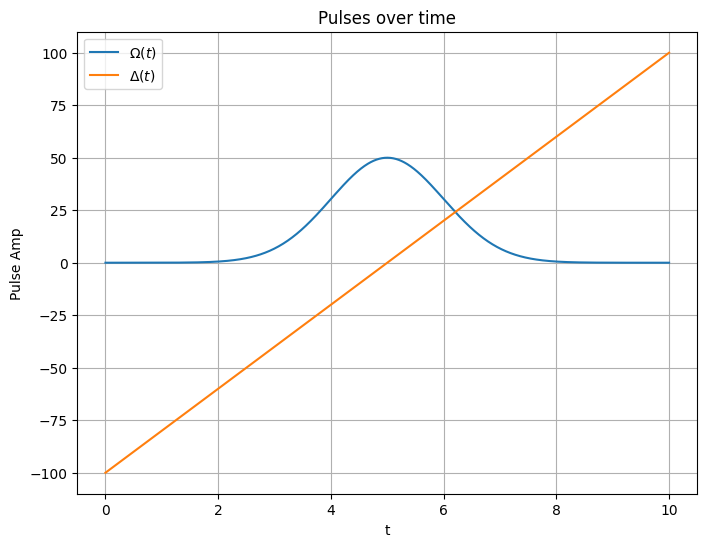

In [494]:
# defining time dependant coefs
T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_t = 50 * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 100*(t / (T/2) - 1)

# Plot the wave
plt.figure(figsize=(8, 6))
plt.plot(t, omega_t, label=r'$\Omega(t)$')
plt.plot(t, delta_t, label=r'$\Delta(t)$')
plt.xlabel("t")
plt.ylabel("Pulse Amp")
plt.grid(True)
plt.legend()
plt.title("Pulses over time")


In [238]:
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# Define the stabilizer generators for the 5-qubit bit-flip code
g1 = tensor(X, X, X, X)
g2 = tensor(Z, Z, Z, Z)
g3 = tensor(X, Y, Z, I)

stabilizers = [
    g1,
    g2,
    g3
]

H_x = tensor(Y, I, Y, I)
H_z = tensor(Z, Z, I, I)

In [495]:
basis_states = [basis(2, 0), basis(2, 1)]

# Define the logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                1j*tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1]) +
                1j*tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0]) +
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1])).unit()

logical_X = tensor(Y, I, Y, I)
logical_Y = -tensor(I, X, X, I)
logical_Z = tensor(Z, Z, I, I)


logical_one = logical_X * logical_zero

# Applying error
error = tensor(I, X, I, X)
logical_zero = error * logical_zero
logical_one = error * logical_one

print_quantum_state_as_superposition(logical_zero)
print_quantum_state_as_superposition(logical_one)

P0 = logical_zero * logical_zero.dag()
P1 = logical_one * logical_one.dag()

P_tot = P0 + P1

result_zero = is_stabilized(logical_zero, stabilizers)
result_one = is_stabilized(logical_one, stabilizers)
print(f"Logical |0_L> is stabilized: {result_zero[1]} and the syndrom is {result_zero[0]}")
print(f"Logical |1_L> is stabilized: {result_one[1]} and the syndrom is {result_one[0]}")

|ψ⟩ = 0.50|0101⟩ + 0.50i|0110⟩ + 0.50i|1001⟩ + 0.50|1010⟩
|ψ⟩ = -0.50|0000⟩ + 0.50i|0011⟩ + 0.50i|1100⟩ - 0.50|1111⟩
Logical |0_L> is stabilized: False and the syndrom is [0, 0, 1]
Logical |1_L> is stabilized: False and the syndrom is [0, 0, 1]


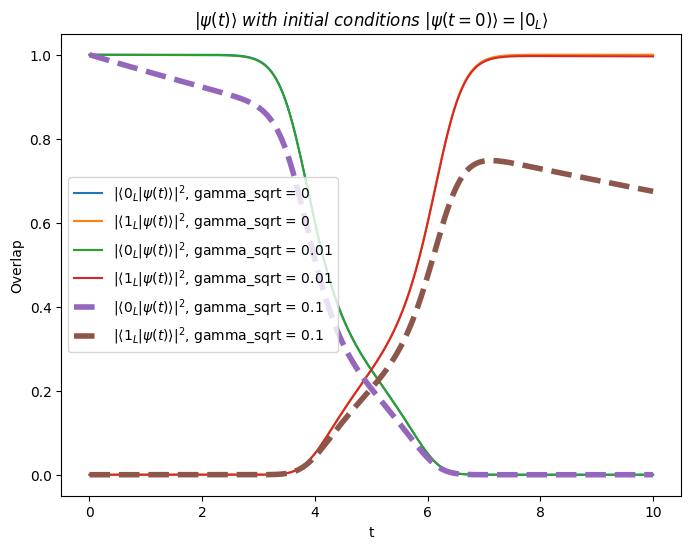

In [509]:
gamma_sqrts = [0, 0.01, 0.1]
plt.figure(figsize=(8, 6))

# H_x_P = P_tot*H_x*P_tot
# H_z_P = P_tot*H_z*P_tot
# g_P = P_tot * (g1 + g2 + g3) * P_tot

for i, gamma_sqrt in enumerate(gamma_sqrts):
    Ep = 0.1
    # Hp_P = -Ep*g_P
    Hp = -Ep*(g1 + g2 + g3)

    C_op = gamma_sqrt * sigmam()
    collapse_ops = [
        tensor(C_op, I, I, I),
        tensor(I, C_op, I, I),
        tensor(I, I, C_op, I),
        tensor(I, I, I, C_op)
    ]
    
    # collapse_ops = [P_tot*i*P_tot for i in collapse_ops]

    # Define time-dependent Hamiltonian
    # H_S_P = [[H_x_P, omega_t], [H_z_P, delta_t], Hp]
    H_S = [[H_x, omega_t], [H_z, delta_t], Hp]
    
    output = mesolve(H_S, logical_zero, t, collapse_ops, [])

    expect_psi_0 = []
    expect_psi_1 = []

    for index, state in enumerate(output.states):
        expect_stat_psi_0 = np.abs(logical_zero.overlap(state))**2
        expect_stat_psi_1 = np.abs(logical_one.overlap(state))**2
        
        expect_psi_0.append(expect_stat_psi_0)
        expect_psi_1.append(expect_stat_psi_1)

    eigenvalues_0 = np.array(expect_psi_0)
    eigenvalues_1 = np.array(expect_psi_1)

    # Plotting the results
    if i == (len(gamma_sqrts) - 1):
        plt.plot(t, eigenvalues_0, '--', label=r'$|\langle 0_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt), linewidth=4)
        plt.plot(t, eigenvalues_1, '--', label=r'$|\langle 1_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt), linewidth=4)
    else:
        plt.plot(t, eigenvalues_0, label=r'$|\langle 0_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt))
        plt.plot(t, eigenvalues_1, label=r'$|\langle 1_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt))

plt.legend()
plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = |0_L\rangle$')
plt.xlabel("t")
plt.ylabel("Overlap")
plt.show()

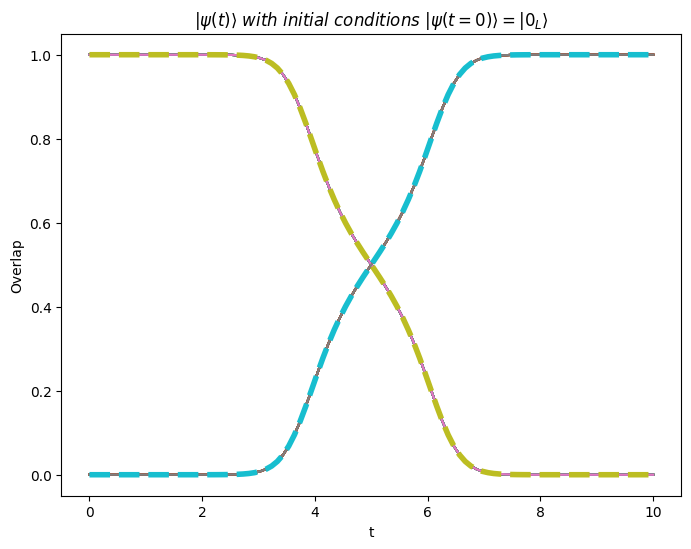

In [469]:
Eps = np.linspace(-10, 10, 30)

# defining time dependant coefs
T = 10
sigma = 1

t = np.linspace(0, T, 100)
omega_t = 50 * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)
delta_t = 100*(t / (T/2) - 1)

H_X_P = P_tot * H_x * P_tot
H_Z_P = P_tot * H_z * P_tot
Stab_sum = P_tot * (g1 + g2 + g3) * P_tot

plt.figure(figsize=(8, 6))

for i, Ep in enumerate(Eps):
    Hp = -Ep*(g1 + g2 + g3)

    gamma_sqrt = 0
    C_op = gamma_sqrt * sigmam()
    collapse_ops = [
        tensor(C_op, I, I, I),
        tensor(I, C_op, I, I),
        tensor(I, I, C_op, I),
        tensor(I, I, I, C_op)
    ]

    # Define time-dependent Hamiltonian
    H_S = [[H_x, omega_t], [H_z, delta_t], Hp]

    output = mesolve(H_S, logical_zero, t, collapse_ops, [])

    expect_psi_0 = []
    expect_psi_1 = []

    for index, state in enumerate(output.states):
        expect_stat_psi_0 = logical_zero.overlap(P_tot*state)
        expect_stat_psi_1 = logical_one.overlap(P_tot*state)

        expect_psi_0.append(expect_stat_psi_0)
        expect_psi_1.append(expect_stat_psi_1)

    eigenvalues_0 = np.array(expect_psi_0)
    eigenvalues_1 = np.array(expect_psi_1)

    # Plotting the results
    if i == (len(Eps) - 1):
        plt.plot(t, eigenvalues_0, '--', label=r'$|\langle 0_L | \psi(t) \rangle|^2$, Ep = {}'.format(Ep), linewidth=4)
        plt.plot(t, eigenvalues_1, '--', label=r'$|\langle 1_L | \psi(t) \rangle|^2$, Ep = {}'.format(Ep), linewidth=4)
    else:
        plt.plot(t, eigenvalues_0, label=r'$|\langle 0_L | \psi(t) \rangle|^2$, Ep = {}'.format(Ep))
        plt.plot(t, eigenvalues_1, label=r'$|\langle 1_L | \psi(t) \rangle|^2$, Ep = {}'.format(Ep))

# plt.legend()
plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = |0_L\rangle$')
plt.xlabel("t")
plt.ylabel("Overlap")
plt.show()

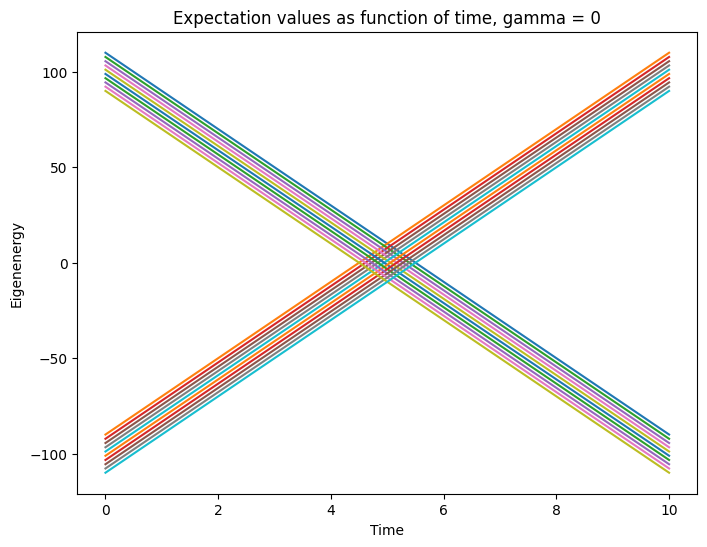

In [472]:
Eps = np.linspace(-10, 10, 10)

plt.figure(figsize=(8, 6))
colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
    'magenta', 'yellow', 'lime', 'teal', 'gold', 'navy'
]

for Ep in Eps:
    Hp = -Ep*(g1 + g2 + g3)
    
    gamma_sqrt = 0
    C_op = gamma_sqrt * sigmam()
    collapse_ops = [
        tensor(C_op, I, I, I),
        tensor(I, C_op, I, I),
        tensor(I, I, C_op, I),
        tensor(I, I, I, C_op),
    ]
    
    omega_t_f = lambda t: 50 * np.exp(-0.5 * ((t - T / 2) / sigma) ** 2)
    
    delta_t_f = lambda t: 100 * (t / (T / 2) - 1)
    
    def get_full_hamiltonian(t_step):
        H_time_dependent = omega_t_f(t_step) * H_x + delta_t_f(t_step) * H_z + Hp
        return H_time_dependent
    
    def get_effective_hamiltonian(t_step):
        """
        https://arxiv.org/pdf/2201.05367
        eq 24
        """
        H_t = get_full_hamiltonian(t_step)
        H_eff = H_t - 0.5j * sum([c.dag() * c for c in collapse_ops])  # Non-Hermitian Hamiltonian
        return H_eff
    
    time_steps = np.linspace(0, 10, 100)  # Adjust the range and number of points
    
    expectations_over_time_zero = []
    expectations_over_time_one = []
    
    for t_step in time_steps:
        H_eff_t = P_tot * get_effective_hamiltonian(t_step) * P_tot
        expectations_over_time_zero.append(expect(H_eff_t, logical_zero))
        expectations_over_time_one.append(expect(H_eff_t, logical_one))
    
    expectations_over_time_zero = np.array(expectations_over_time_zero)
    expectations_over_time_one = np.array(expectations_over_time_one)
    
    plt.plot(time_steps, expectations_over_time_zero, label=r'$\langle 0 | H_{S}(t) | 0 \rangle$' + ', Ep = ' + str(Ep))
    plt.plot(time_steps, expectations_over_time_one, label=r'$\langle 1 | H_{S}(t) | 1 \rangle$' + ', Ep = ' + str(Ep))

plt.xlabel('Time')
plt.ylabel('Eigenenergy')
plt.title('Expectation values as function of time, gamma = 0')
# plt.legend()
# plt.ylim([-20,20])
plt.show()

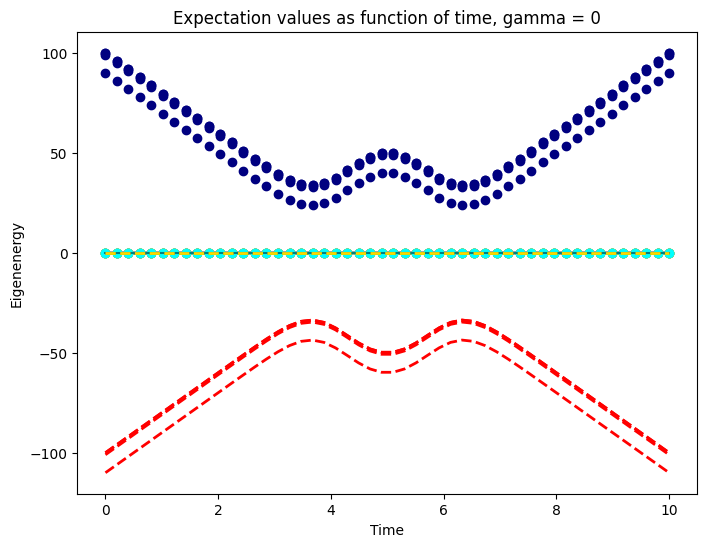

In [511]:
Eps = [0, 0.0001, 1, 10]

plt.figure(figsize=(8, 6))
colors = [
    'red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan',
    'magenta', 'yellow', 'lime', 'teal', 'gold', 'navy'
]

for Ep in Eps:
    Hp = -Ep*(g1 + g2 + g3)
    
    gamma_sqrt = 0
    C_op = gamma_sqrt * sigmam()
    collapse_ops = [
        tensor(C_op, I, I, I),
        tensor(I, C_op, I, I),
        tensor(I, I, C_op, I),
        tensor(I, I, I, C_op),
    ]
    
    omega_t_f = lambda t: 50 * np.exp(-0.5 * ((t - T / 2) / sigma) ** 2)
    
    delta_t_f = lambda t: 100 * (t / (T / 2) - 1)
    
    def get_full_hamiltonian(t_step):
        H_time_dependent = omega_t_f(t_step) * H_x + delta_t_f(t_step) * H_z + Hp
        return H_time_dependent
    
    def get_effective_hamiltonian(t_step):
        """
        https://arxiv.org/pdf/2201.05367
        eq 24
        """
        H_t = get_full_hamiltonian(t_step)
        H_eff = H_t - 0.5j * sum([c.dag() * c for c in collapse_ops])  # Non-Hermitian Hamiltonian
        return H_eff
    
    time_steps = np.linspace(0, 10, 50)  # Adjust the range and number of points
    
    eigenenergies_over_time = []

    
    for t_step in time_steps:
        H_eff_t = P_tot * get_effective_hamiltonian(t_step) * P_tot
        eigenenergies = H_eff_t.eigenenergies()
        eigenenergies_over_time.append(eigenenergies)
    
    eigenenergies_over_time = np.array(eigenenergies_over_time)

    for i in range(eigenenergies_over_time.shape[1]):
        if i % 2 == 0:
            plt.plot(time_steps, np.real(eigenenergies_over_time[:, i]), "--", label=f'Eigenvalue {i+1} (Real part), Ep = {Ep}', color=colors[i], linewidth=2)
        elif i % 3 == 0:
            plt.plot(time_steps, np.real(eigenenergies_over_time[:, i]), "o",label=f'Eigenvalue {i+1} (Real part), Ep = {Ep}', color=colors[i])
        else:
            plt.plot(time_steps, np.real(eigenenergies_over_time[:, i]),label=f'Eigenvalue {i+1} (Real part), Ep = {Ep}', color=colors[i])

plt.xlabel('Time')
plt.ylabel('Eigenenergy')
plt.title('Expectation values as function of time, gamma = 0')
# plt.legend()
# plt.ylim([-20,20])
plt.show()

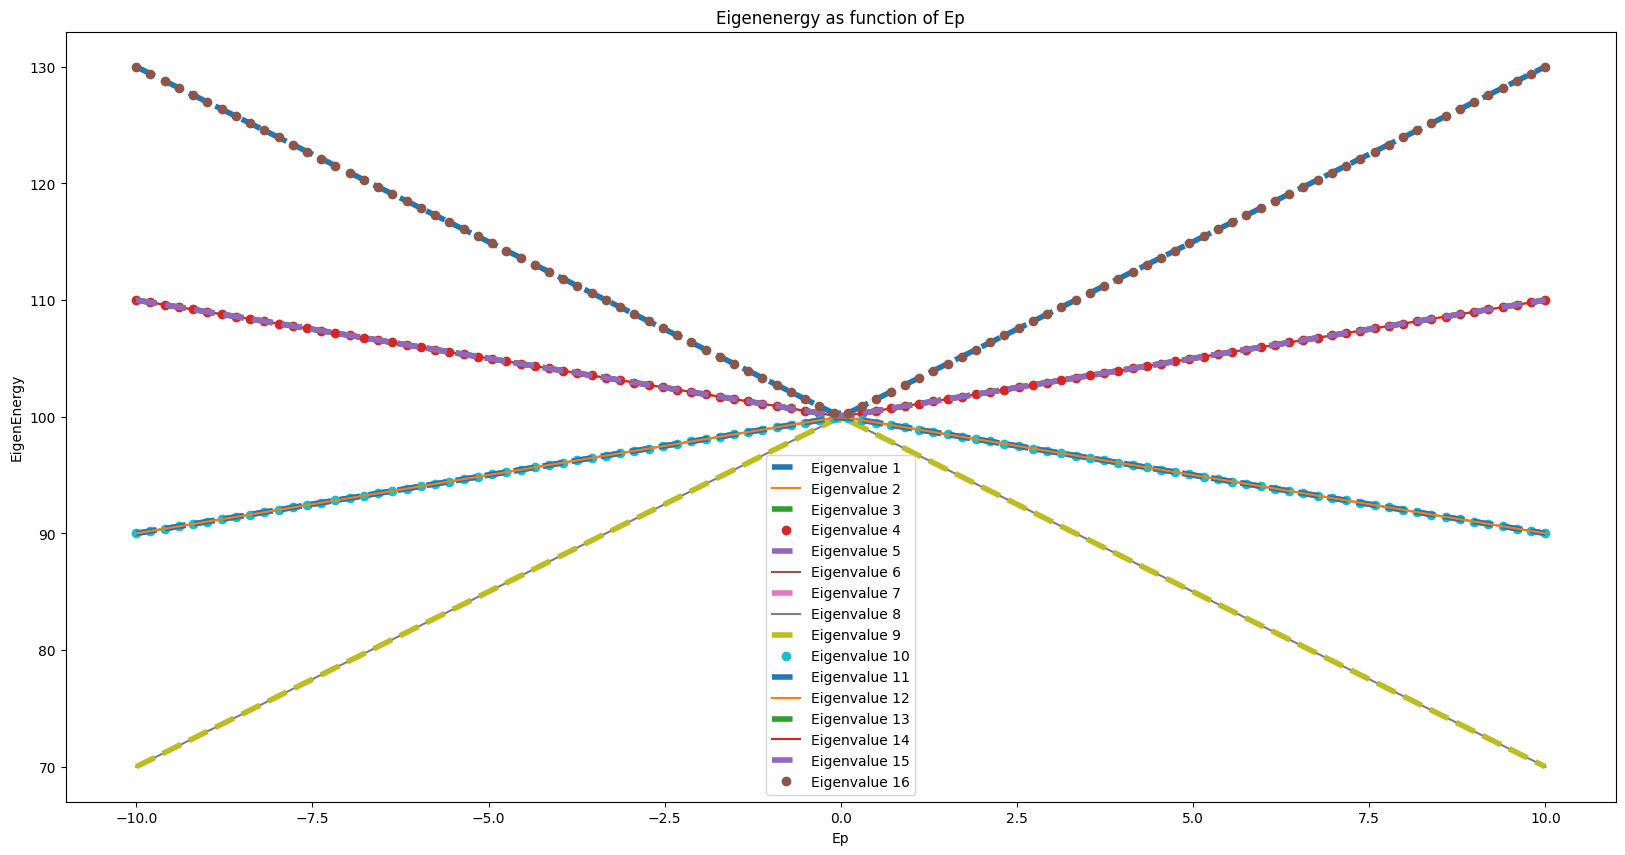

In [512]:
plt.figure(figsize=(20, 10))

eigenenergies_values = []

omega_t_f = lambda t: 50 * np.exp(-0.5 * ((t - T / 2) / sigma) ** 2)
delta_t_f = lambda t: 100 * (t / (T / 2) - 1)

Eps = np.linspace(-10,10,100)

P0 = logical_zero * logical_zero.dag()  # Projector for logical 0
P1 = logical_one * logical_one.dag()  # Projector for logical 1

P_tot = P0 + P1

for Ep in Eps:
    Hp = -Ep*(g1 + g2 + g3)
    
    H_0 = omega_t_f(0) * H_x + delta_t_f(0) * H_z + Hp
    eigenenergies_values.append(H_0.eigenenergies())
    
eigenenergies_values = np.abs(eigenenergies_values)


for i in range(eigenenergies_values.shape[1]):  # Loop over each eigenvalue
    if i % 2 == 0:
        plt.plot(Eps, eigenenergies_values[:, i], "--", label=f'Eigenvalue {i+1}', linewidth=4)
    elif i % 3 == 0:
        plt.plot(Eps, eigenenergies_values[:, i], "o", label=f'Eigenvalue {i+1}')
    else:
        plt.plot(Eps, eigenenergies_values[:, i], label=f'Eigenvalue {i+1}')     
plt.xlabel('Ep')
plt.ylabel('EigenEnergy')
plt.title('Eigenenergy as function of Ep')
plt.legend()
# plt.ylim([-20,20])
plt.show()

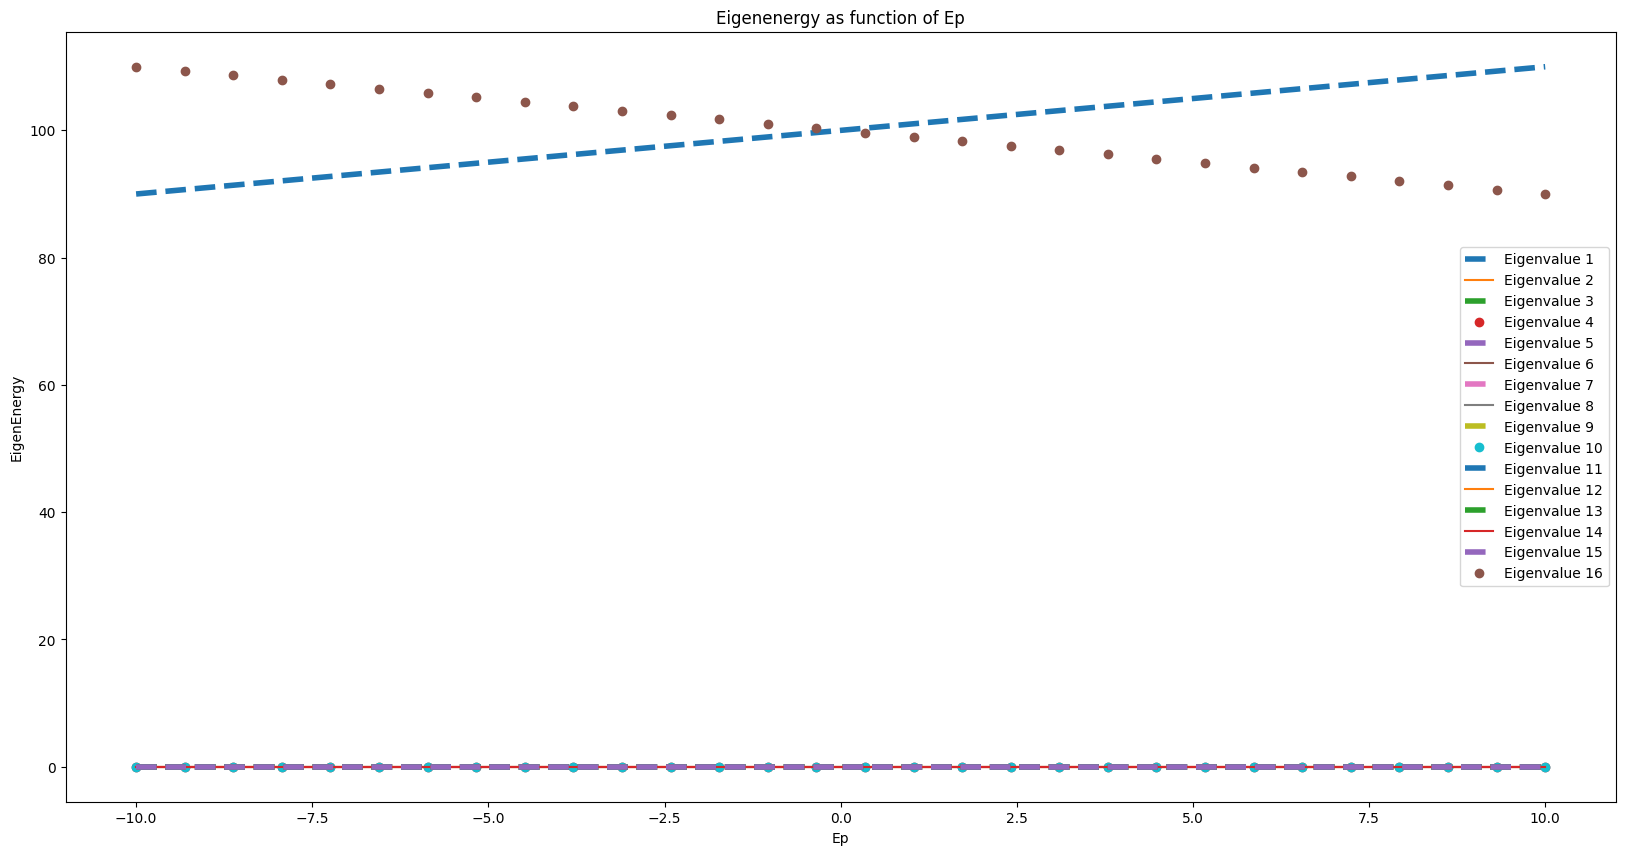

In [541]:
plt.figure(figsize=(20, 10))


sigma = 1
omega_t_f = lambda t: 50 * np.exp(-0.5 * ((t - T / 2) / sigma) ** 2)
delta_t_f = lambda t: 100 * (t / (T / 2) - 1)

Eps = np.linspace(-10,10,30)

eigenenergies_values = []

for Ep in Eps:
    Hp = -Ep*(g1 + g2 + g3)
    
    H_0 = omega_t_f(0) * H_x + delta_t_f(0) * H_z + Hp
    H_0_P = P_tot * H_0 * P_tot

    eigenenergies_values.append(H_0_P.eigenenergies())

eigenenergies_values = np.abs(eigenenergies_values)


for i in range(eigenenergies_values.shape[1]):  # Loop over each eigenvalue
    if i % 2 == 0:
        plt.plot(Eps, eigenenergies_values[:, i], "--", label=f'Eigenvalue {i+1}', linewidth=4)
    elif i % 3 == 0:
        plt.plot(Eps, eigenenergies_values[:, i], "o", label=f'Eigenvalue {i+1}')
    else:
        plt.plot(Eps, eigenenergies_values[:, i], label=f'Eigenvalue {i+1}')
        
plt.xlabel('Ep')
plt.ylabel('EigenEnergy')
plt.title('Eigenenergy as function of Ep')
plt.legend()
plt.show()

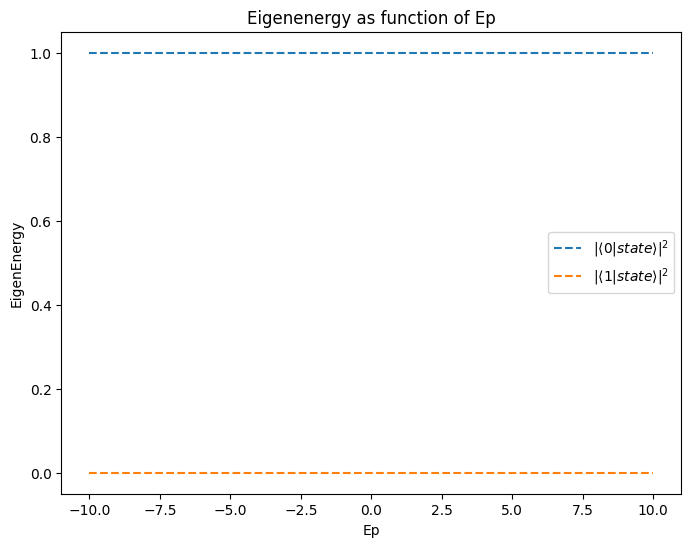

In [520]:
plt.figure(figsize=(8, 6))

project_psi_0 = []
project_psi_1 = []

Eps = np.linspace(-10,10,3)


sigma = 1
omega_t_f = lambda t: 50 * np.exp(-0.5 * ((t - T / 2) / sigma) ** 2)
delta_t_f = lambda t: 100 * (t / (T / 2) - 1)


for Ep in Eps:
    Hp = -Ep*(g1 + g2 + g3)
    
    # H_S = [[H_x, omega_t_f], [H_z, delta_t_f], Hp]
    H_S = [[P_tot*H_x*P_tot, omega_t_f], [P_tot*H_z*P_tot, delta_t_f], P_tot*Hp*P_tot]
        
    gamma_sqrt = 0.01
    C_op = gamma_sqrt * sigmam()
    # collapse_ops = [
    #     tensor(C_op, I, I, I),
    #     tensor(I, C_op, I, I),
    #     tensor(I, I, C_op, I),
    #     tensor(I, I, I, C_op),
    # ]
    
    collapse_ops = [
        P_tot*tensor(C_op, I, I, I)*P_tot,
        P_tot*tensor(I, C_op, I, I)*P_tot,
        P_tot*tensor(I, I, C_op, I)*P_tot,
        P_tot*tensor(I, I, I, C_op)*P_tot,
    ]

    output = mesolve(H_S, logical_zero, t, collapse_ops, [])
    
    state_at_t_0 = output.states[0]
    project_0_L = np.abs(logical_zero.overlap(state_at_t_0))**2
    project_1_L = np.abs(logical_one.overlap(state_at_t_0))**2

    project_psi_0.append(project_0_L)
    project_psi_1.append(project_1_L)

project_psi_0 = np.array(project_psi_0)
project_psi_1 = np.array(project_psi_1)

plt.plot(Eps, project_psi_0, "--", label=r'$| \langle 0 | state \rangle | ^2$')
plt.plot(Eps, project_psi_1, "--", label=r'$| \langle 1 | state \rangle | ^2$')

plt.xlabel('Ep')
plt.ylabel('EigenEnergy')
plt.title('Eigenenergy as function of Ep')
plt.legend()
plt.show()